# 팀 과제(2024-01-15 까지)

# 1. 데이터


### 1-1. 데이터 불러오기


In [62]:
import os

os.environ['KAGGLE_USERNAME'] = 'pepidev'
os.environ['KAGGLE_KEY'] = '982c120e8dea60a4a016b383ea4749f7'

In [63]:
!kaggle datasets download -d jehanbhathena/weather-dataset

weather-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [64]:
!unzip -q weather-dataset.zip

### 1-2. train, validation 나누기

In [65]:
import os
import random
import shutil

def split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2):
    # 클래스 폴더 목록 가져오기
    classes = os.listdir(dataset_path)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        train_class_path = os.path.join(train_path, class_name)
        validation_class_path = os.path.join(validation_path, class_name)

        # 폴더 생성
        if not os.path.exists(train_class_path):
            os.makedirs(train_class_path)
        if not os.path.exists(validation_class_path):
            os.makedirs(validation_class_path)

        # 클래스 폴더 내의 파일 목록 가져오기
        file_list = os.listdir(class_path)

        # 클래스 별 데이터셋 섞기
        random.shuffle(file_list)

        # 클래스 별 데이터셋을 train과 validation으로 나누기
        num_validation = int(len(file_list) * validation_ratio)
        validation_files = file_list[:num_validation]
        train_files = file_list[num_validation:]

        # validation 폴더로 파일 이동
        for file in validation_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(validation_class_path, file)
            shutil.move(src_path, dest_path)

        # train 폴더로 파일 이동
        for file in train_files:
            src_path = os.path.join(class_path, file)
            dest_path = os.path.join(train_class_path, file)
            shutil.move(src_path, dest_path)

# 사용 예시
dataset_path = 'dataset'
train_path = 'train'
validation_path = 'validation'

split_dataset_by_class(dataset_path, train_path, validation_path, validation_ratio=0.2)


In [66]:
train_list_dew = os.listdir('train/dew')
valid_list_dew = os.listdir('validation/dew')

print(len(train_list_dew), len(valid_list_dew))

663 243


### 1-3. 모듈 설정, dataset 객체 만들기

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

def target_transforms(target):
    return torch.FloatTensor([target])

image_datasets = {
    'train': datasets.ImageFolder('train', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('validation', data_transforms['validation'], target_transform=target_transforms)
}

# label을 float형으로 변경함
# label의 차원이 2D임, 각 요소는 1D
# target_transform=target_transforms를 하지 않으면 각 요소는 long타입에 0D임

cuda


In [68]:
print(len(image_datasets['train']), len(image_datasets['validation']))

6558 2434


### 1-4. 데이터 로더

In [69]:
dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size=32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['validation'],
        batch_size=32,
        shuffle=False
    )
}

In [70]:
x_batch, y_batch = next(iter(dataloaders['train']))
print(y_batch.shape)
print(x_batch.shape)

torch.Size([32, 1])
torch.Size([32, 3, 224, 224])


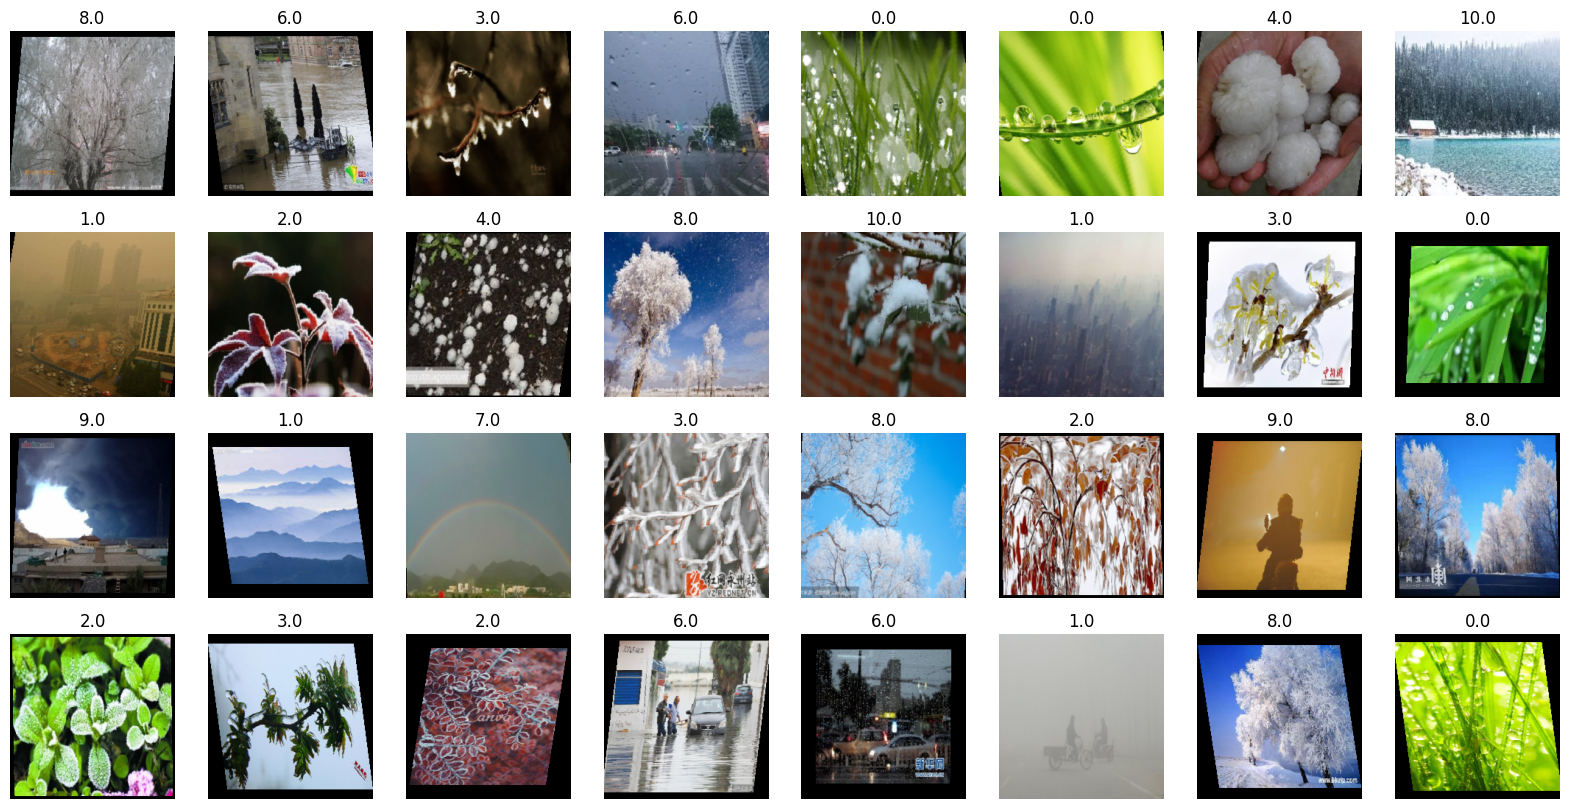

In [71]:
imgs, labels = next(iter(dataloaders['train']))
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for img, label, ax in zip(imgs, labels, axes.flatten()):
    ax.set_title(label.item())
    ax.imshow(img.permute(1, 2, 0))
    ax.axis('off')

# 2. 학습


### Yolo 모델 사용해보기


In [81]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# YOLO 모델 정의
class YOLOModel(nn.Module):
    def __init__(self, num_classes):
        super(YOLOModel, self).__init__()
        self.yolo_model = models.resnet50(pretrained=True)
        in_features = self.yolo_model.fc.in_features
        self.yolo_model.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.yolo_model(x)

# 모델 생성
num_classes = len(image_datasets['train'].classes)
yolo_model = YOLOModel(num_classes)

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
yolo_model.to(device)

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(yolo_model.parameters(), lr=0.001)

# 학습 및 검증 함수 정의
def train_model(model, criterion, optimizer, num_epochs=5, accumulation_steps=4):
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0

        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.long())

            loss.backward()

            # Gradient accumulation
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(torch.argmax(outputs, 1) == labels.data)

        epoch_loss = running_loss / len(image_datasets['train'])
        epoch_acc = running_corrects.double() / len(image_datasets['train'])

        print(f'Epoch {epoch + 1}/{num_epochs} - Training Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}')

# 모델 학습
train_model(yolo_model, criterion, optimizer, num_epochs=5)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 56 * 56, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 56 * 56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, dataloaders, criterion, optimizer, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # 학습 및 검증 loss를 저장하기 위한 리스트
    train_loss_history = []
    validation_loss_history = []

    for epoch in range(num_epochs):
        # 학습 단계
        model.train()
        running_loss = 0.0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        epoch_train_loss = running_loss / len(dataloaders['train'])
        train_loss_history.append(epoch_train_loss)

        # 검증 단계
        model.eval()
        running_loss = 0.0
        with torch.no_grad():
            for inputs, labels in dataloaders['validation']:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

        epoch_validation_loss = running_loss / len(dataloaders['validation'])
        validation_loss_history.append(epoch_validation_loss)

        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Validation Loss: {epoch_validation_loss:.4f}")

    return model, train_loss_history, validation_loss_history

# 모델, 손실 함수, 옵티마이저 정의
num_classes = len(image_datasets['train'].classes)
model = SimpleCNN(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 모델 학습
trained_model, train_loss_history, validation_loss_history = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

# 학습과 검증 손실 그래프 그리기
plt.plot(train_loss_history, label='Train Loss')
plt.plot(validation_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


아니 ㅣㅏㅁ써낟ㄹ;ㅓㅣㄴ이';닌ㄹㅇㄴ ㄹㅇ ㅎㄴ ㄴㅇ;
 ㄴㄹ
 \ㅁ ㄴㄷㅎ ㅁ;ㅁ;ㅁ ㄴㅁ ㄹ;너 ㅁ;머ㅓ ㄴ ㅁ;ㅏㄴㄹ아ㅓㅣㅏ;ㅓㅇ난이ㅏ;럼너ㅣ;ㅁㄴㅇ;ㅚ ㅣ;ㅓㅣ;;ㅁㄴ;ㅓ; 왜 안되냐고